In [57]:
%load_ext autoreload
%autoreload 2

from cleaning_text import detect_language, is_not_string, process_in_batches
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import pandas as pd
import spacy
import emoji
import nltk
from nltk.corpus import stopwords
import demoji
import re

# Download the stopword corpus
nltk.download('stopwords')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandonbell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('TIKTOK_REVIEWS.csv', index_col=0)

df.loc[df['review_rating'] >= 4,'sentiment'] = "positive"
df.loc[df['review_rating'] == 3,'sentiment'] = "neutral"
df.loc[df['review_rating'] < 3,'sentiment'] = "negative"

In [4]:
df.head()

review_id       pseudo_author_id  \
0  c6f14d9b-61ec-455c-9b11-9d05331362c2  392735140710813970788   
1  f5640090-ebc7-472a-824b-ebf89155b363  939952661006796816839   
2  40c98362-a25d-4f20-9fb4-1ef46e736728  160177883577467325216   
3  898bb970-f8da-4f2f-b83b-68aae71974c1  466026669372387032245   
4  6796d65a-b2ab-4042-9d68-241895d7048d  108678948795919826063   

       author_name               review_text  review_rating  review_likes  \
0       Ad******as               Adil_abbas7              5             0   
1   Re**********is                  best app              5             0   
2       Al******an  Gondal Badsha Mandi alaa              5             0   
3   Mu**********id                 Ubaidgame              5             0   
4  Am***********de                  Best app              5             0   

  author_app_version     review_timestamp sentiment  
0             17.4.2  2020-08-16 17:46:05  positive  
1             17.3.4  2020-08-16 17:46:05  positive  
2             16.3.5  2020-08-16 17:46:18  positive  
3             17.2.4  2020-08-16 17:46:27  positive  
4                NaN  2020-08-16 17:46:44  positive

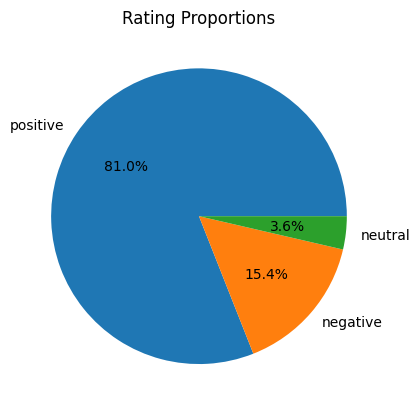

In [5]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Rating Proportions')
plt.ylabel('')
plt.show()

### Checking for non-string reviews

In [6]:
batch_size = 100000

non_string_rows = pd.DataFrame(columns=df.columns)

for start in tqdm(range(0, len(df), batch_size), desc="Processing"):
    end = min(start + batch_size, len(df))
    batch = df.iloc[start:end]
    non_string_batch = batch[batch['review_text'].apply(is_not_string)]
    non_string_rows = pd.concat([non_string_rows, non_string_batch], ignore_index=True)

Processing: 100%|██████████| 35/35 [00:00<00:00, 35.66it/s]


In [9]:
# checking if the text without string are all null
non_string_rows['review_text'].isna().sum() == len(non_string_rows)

True

In [10]:
# dropping na values
df.dropna(subset=['review_text'], inplace=True)

### Determing the Languages Used in Text

In [11]:
# Assuming your data is in a DataFrame called 'df' and the column of interest is 'text_column'
sample_size = 0.01  # 5% of the dataset
sampled_df = df.sample(frac=sample_size)

In [15]:
# Detecting the languages to consider
sampled_df['detected_language'] = sampled_df['review_text'].apply(detect_language)

In [46]:
# it appears that those labeled unknown contain emojis
sampled_df[sampled_df['detected_language'] == 'unknown'].head(2)

review_id       pseudo_author_id  \
1091110  596a553b-2542-47ba-bbce-7f564a4462a2  255368606784021282471   
1709501  2c0120e1-5fcf-45af-b4b4-95ed09718f54  228264990245916219009   

            author_name  review_text  review_rating  review_likes  \
1091110    Ab********se  ❤️ 🌹 🦋 🏆 🏌️              5             0   
1709501  Mu**********dd            🤚              5             0   

        author_app_version     review_timestamp sentiment detected_language  
1091110             20.3.3  2021-07-14 22:00:31  positive           unknown  
1709501             21.3.3  2022-01-17 07:28:01  positive           unknown

### Data Pre-Processing

In [48]:
# Most Frequent Languages
is_more_than_1_percent = sampled_df['detected_language'].value_counts(normalize=True) >= 0.01
most_frequent_languages = list(is_more_than_1_percent.index[is_more_than_1_percent == True])

# Least Frequent Languages
is_less_than_1_percent = sampled_df['detected_language'].value_counts(normalize=True) < 0.01
less_frequent_languages = list(is_less_than_1_percent.index[is_less_than_1_percent == True])

# All Languages under 1 % frequency converted to 'other'
sampled_df.loc[sampled_df['detected_language'].isin(less_frequent_languages),'detected_language'] = 'other'

In [70]:
# Custom Stopwords

somali_stopwords = ["iyo", "oo", "waa", "ka", "in", "la", "ay"]
slovak_stopwords = ["a", "ale", "si", "sa", "že", "na", "pre"]
slovenian_stopwords = ["in", "je", "da", "na", "se", "za", "ali"]
tagalog_stopwords = ["ang", "sa", "ng", "ay", "at", "na", "mga"]
estonian_stopwords = ["ja", "on", "et", "ei", "ka", "see", "kui"]
afrikaans_stopwords = ["aan", "af", "al", "as", "baie", "by", "daar", "dag", "dat", "die", "dit", "een", "ek", "en", 
    "gaan", "gesê", "haar", "het", "hom", "hulle", "hy", "in", "is", "jou", "jy", "kan", "kom", 
    "ma", "maar", "met", "my", "na", "nie", "nog", "om", "ons", "op", "saam", "sal", "se", 
    "sien", "so", "sy", "te", "toe", "uit", "van", "vir", "was", "wat", "ŉ"]
swahili_stopwords = [
    "akasema", "alikuwa", "alisema", "baada", "basi", "bila", "cha", "chini", "hadi", "hapo", 
    "hata", "hivyo", "hiyo", "huku", "huo", "ili", "ilikuwa", "juu", "kama", "karibu", "katika", 
    "kila", "kima", "kisha", "kubwa", "kutoka", "kuwa", "kwa", "kwamba", "kwenda", "kwenye", 
    "la", "lakini", "mara", "mdogo", "mimi", "mkubwa", "mmoja", "moja", "muda", "mwenye", 
    "na", "naye", "ndani", "ng", "ni", "nini", "nonkungu", "pamoja", "pia", "sana", "sasa", 
    "sauti", "tafadhali", "tena", "tu", "vile", "wa", "wakati", "wake", "wala", "wale", "wao", 
    "watu", "wengine", "wote", "ya", "yake", "yangu", "yao", "yeye", "yule", "za", "zaidi", "zake"
]
polish_stopwords =["a", "aby", "ach", "acz", "aczkolwiek", "aj", "albo", "ale", "ależ", "ani", "aż", "bardziej", 
    "bardzo", "bo", "bowiem", "by", "być", "był", "była", "byli", "było", "były", "będzie", 
    "będą", "cali", "cała", "cały", "ci", "cię", "ciebie", "co", "cokolwiek", "coś", "czasami", 
    "czasem", "czemu", "czy", "czyli", "daleko", "dla", "dlaczego", "dlatego", "do", "dobrze", 
    "dokąd", "dość", "dużo", "dwa", "dwaj", "dwie", "dwoje", "dziś", "dzisiaj", "gdy", "gdyby", 
    "gdyż", "gdzie", "gdziekolwiek", "gdzieś", "i", "ich", "ile", "im", "inna", "inne", "inny", 
    "innych", "iż", "ja", "ją", "jak", "jakaś", "jakby", "jaki", "jakichś", "jakie", "jakiś", 
    "jakiż", "jakkolwiek", "je", "jeden", "jedna", "jednak", "jednakże", "jedno", "jego", 
    "jej", "jemu", "jest", "jestem", "jeszcze", "jeśli", "jeżeli", "już", "ją", "każdy", "kiedy", 
    "kilka", "kimś", "kto", "ktokolwiek", "ktoś"]


language_stopwords = {
    'en': stopwords.words('english'),  # English
    'so': somali_stopwords,  # Somali
    'ro': stopwords.words('romanian'),  # Romanian
    'af': afrikaans_stopwords,  # Afrikaans
    'it': stopwords.words('italian'),  # Italian
    'no': stopwords.words('norwegian'),  # Norwegian
    'de': stopwords.words('german'),  # German
    'sk': slovak_stopwords,  # Slovak
    'id': stopwords.words('indonesian'),  # Indonesian
    'sw': swahili_stopwords,  # Swahili
    'fr': stopwords.words('french'),  # French
    'sl': slovenian_stopwords,  # Slovenian
    'tl': tagalog_stopwords,  # Tagalog
    'pl': polish_stopwords,  # Polish
    'ca': stopwords.words('catalan'),  # Catalan
    'et': estonian_stopwords,  # Estonian
    'unknown': stopwords.words('english')
}

In [65]:
# Will handle text with emojis. Tokenizer

def tokenize_with_demoji_and_replace(text):
    # Find all emojis in the text and their descriptions
    emoji_descriptions = demoji.findall(text)

    # If there are no emojis, simply split the text
    if not emoji_descriptions:
        return text.split()

    # Replace each emoji with its text description
    for emoji, description in emoji_descriptions.items():
        # Add delimiters around the description if desired, e.g., "_description_"
        text = text.replace(emoji, f' {description} ')

    # Split the text into words and emoji descriptions
    tokens = text.split()
    return tokens

# Example usage
text = "I love pizza 🍕! Do you?"
tokens = tokenize_with_demoji_and_replace(text)
print(tokens)

["Let's", 'go', 'rocket', '!']


In [ ]:
def preprocess_text(text: str, language: str):
    nlp = spacy.load(language)
    doc = nlp(text)
    tokens_lowercase = [token.text.lower() for token in doc]


In [ ]:
# use spacy to incorporate stop words


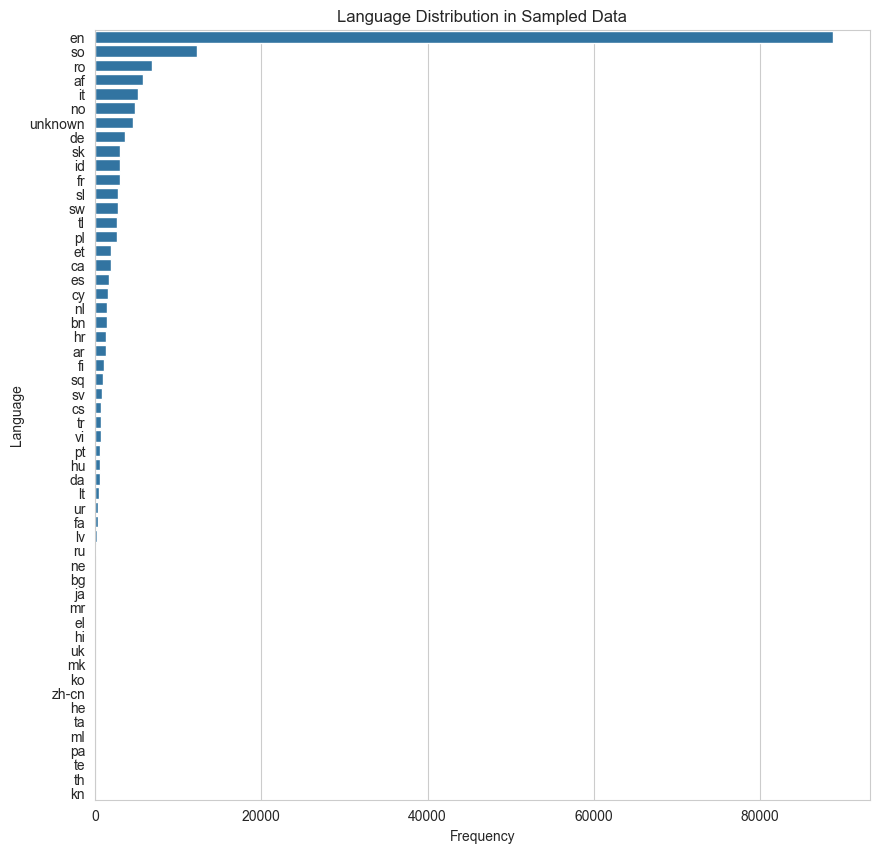

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

language_distribution = sampled_df['detected_language'].value_counts()

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 10))
language_plot = sns.barplot(x=language_distribution.values, y=language_distribution.index)

# Add labels and title
plt.xlabel('Frequency')
plt.ylabel('Language')
plt.title('Language Distribution in Sampled Data')

# Show the plot
plt.show()


In [40]:
sampled_df.to_pickle("sampled_df.pkl")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brandonbell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandonbell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brandonbell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
sampled_df[sampled_df['detected_language'] == 'kn']

review_id       pseudo_author_id  \
1278097  11105085-ab08-4f87-9659-c4b8ab5469fd  288204601447613488456   
628738   b905da12-e7bd-4d98-b024-b2b38e689f9a  382003730384053810540   

                   author_name          review_text  review_rating  \
1278097          Da*********ha             ಟಖಜಢ2457              5   
628738   AR*****************aw  𝕊𝕠 𝕚𝕟𝕥𝕖𝕣𝕖𝕤𝕥𝕚𝕟𝕘ಠ_ಠ🥺💜              5   

         review_likes author_app_version     review_timestamp sentiment  \
1278097             0             20.8.4  2021-08-23 08:48:40  positive   
628738              0             18.5.6  2021-02-18 17:05:46  positive   

        detected_language  
1278097                kn  
628738                 kn

In [45]:
sampled_df['detected_language'].value_counts().sort_values(ascending=True)

detected_language
kn             2
pa             2
th             2
te             2
ml             4
ta             5
he             7
zh-cn         10
ko            11
mk            13
uk            13
hi            14
el            16
mr            19
ja            20
bg            24
ne            31
ru            79
lv           241
fa           332
ur           401
lt           552
da           569
hu           635
pt           667
vi           712
tr           744
cs           777
sv           908
sq           948
fi          1125
ar          1380
hr          1381
bn          1416
nl          1468
cy          1629
es          1716
ca          1917
et          1990
pl          2626
tl          2633
sw          2748
sl          2762
fr          2960
id          2969
sk          2991
de          3559
unknown     4612
no          4793
it          5182
af          5746
ro          6876
so         12298
en         88746
Name: count, dtype: int64

In [55]:
language_counts = sampled_df['detected_language'].value_counts() < 80
rare_languages = language_counts[language_counts.values]
rare_language_names = rare_languages.index.to_list()

In [77]:
rare_language_names

['ru',
 'ne',
 'bg',
 'ja',
 'mr',
 'el',
 'hi',
 'uk',
 'mk',
 'ko',
 'zh-cn',
 'he',
 'ta',
 'ml',
 'pa',
 'te',
 'th',
 'kn']

# Determining the Languages

In [26]:
df['language'] = process_in_batches(df, detect_language, batch_size=100000)

  0%|          | 0/35 [02:38<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
df

In [8]:
df['language'] = df['review_text'].apply(detect_language)

TypeError: expected string or bytes-like object

### Balancing the Dataset

In [7]:
from imblearn.under_sampling import RandomUnderSampler

In [8]:
res = RandomUnderSampler(sampling_strategy={'positive':500000,'negative':500000,'neutral':125000})

In [9]:
X = df['review_text']
X = X.values.reshape(-1, 1)

y = df['sentiment']

In [10]:
# Assuming X and y are your features and labels respectively
X_resampled, y_resampled = res.fit_resample(X, y)

In [19]:
from cleaning_text import preprocess_text, preprocess_texts_parallel

ImportError: cannot import name 'preprocess_texts_parallel' from 'cleaning_text' (/Users/brandonbell/Desktop/coding/sentiment_analysis/cleaning_text.py)

In [18]:
X_resampled.shape

(1125000, 1)

In [ ]:
processed_texts_parallel = preprocess_texts_parallel(X_resampled)

### Vectorization

In [34]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

In [27]:
X_resampled.shape

(1125000, 1)

In [35]:
# Load pre-trained model tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased", return_dict=True)

# Function to process a batch of texts
def process_batch(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Assuming X is a numpy array with shape (3465866, 1)
# Convert X to a 1D array if it's not already
X_resampled = X_resampled.ravel()  # This flattens the array to 1D if needed

# Batch processing
batch_size = 100  # Adjust this based on your system's capabilities
embeddings = []

for start_idx in tqdm(range(0, len(X_resampled), batch_size), desc="Processing"):
    end_idx = start_idx + batch_size
    batch_texts = X_resampled[start_idx:end_idx].tolist()  # Convert batch to list
    batch_embeddings = process_batch(batch_texts)
    embeddings.append(batch_embeddings)

# Concatenate all embeddings
X_embeddings = np.vstack(embeddings)

Processing:   0%|          | 1/11250 [00:54<170:14:35, 54.48s/it]


KeyboardInterrupt: 